# Dynamic optimization

## Intro

In [2]:
# TODO: flow chart

## Init

In [56]:
# imports
import os #to access system folders
import subprocess #to access ffmpeg in the system
import numpy as np #easy vector operations
from scipy.optimize import curve_fit #fittin of the curve
import json #to handle json files
import matplotlib.pyplot as pl #to display plots

#constants
PARAM_AVC = {"crfs": 52, "starting_range": [17,28], "lib": "libx264", "container": "mp4", "add_param": ""}
PARAM_HEVC = {"crfs": 52, "starting_range": [22,33], "lib": "libx265", "container": "mp4", "add_param": ""}
PARAM_VP9 = {"crfs": 64, "starting_range": [15,35], "lib": "libvpx-vp9", "container": "webm", "add_param": "-b:v 0"}

#variables
input_type = "yuv" #valules:"yuv", "y4m", "seq"
codec = "avc" #values: "avc", "hevc", "vp9", "av1", "vvc"

raw_width = 1920 #opz. only for yuv and seq
raw_height = 1080 #opz. only for yuv and seq
raw_fps = 29.97 #opz. only for yuv and seq

source_name = "testscene01"
source_path = "test_vids/srcRAW_FullHD/" + source_name + "." + input_type
ref_path = "test_vids/tempRAW_refs/" #raw files for each shot
dist_path = "test_vids/temp_encoded/" #encoded files for each shot
#assessment files path
tm_file = "rd_results/template.json"
rd_file = "rd_results/" + source_name + ".json"
vmaf_logs = "rd_results/vmaf_logs"

opt_found = True #flag: optimum has been found for the current shot
current_point = 0 #the current optimum point
new_point = 0 #new value to compare with current_point
#TODO: compare with everything stored
res_matrix = {"crf": None, "bitrate": None, "vmaf": None, "psnr": None} #all computed points, by row: crf, bitrate, vmaf, psnr

flag_target = True #values True (quality) or False (bitrate)
quality_metric = "vmaf" #values "vmaf", "psnr", "ssim", "mssim"
#TODO implement more quality metrics
target_bitrate = [12000000]
target_quality = [96]

print("init done")

init done


## Input and shot change detection

In [57]:
def init_res_matrix(x):
    res_matrix["crf"] = np.arange(0,x,1).tolist()
    res_matrix["bitrate"] = np.zeros(x).tolist()
    res_matrix["vmaf"] = np.zeros(x).tolist()
    res_matrix["psnr"] = np.zeros(x).tolist()

In [58]:
struct_points = [] #structure of target points for json file
struct_shots = [] #structure of shots for json file
num_scenes = 3 #TODO: shot change detection

#TODO: support different input raw files
if input_type == "yuv":
    print("yuv input")
elif input_type == "y4m":
    print("y4m input")
else:
    print("No such an input type")
    exit()
    
#init values based on the selected output codec
if codec == "avc":
    s_cod = PARAM_AVC
    init_res_matrix(PARAM_AVC["crfs"])
elif codec == "hevc":
    s_cod = PARAM_HEVC
    init_res_matrix(PARAM_HEVC["crfs"])
elif codec == "vp9":
    s_cod = PARAM_VP9
    init_res_matrix(PARAM_VP9["crfs"])
else:
    print("No such an codec")
    exit()

min_range_crf = s_cod["starting_range"][0]
max_range_crf = s_cod["starting_range"][1]
    
#if not os.path.isfile(rd_file):
    #TODO: duplicate file and rename
with open(tm_file, 'r') as f:
    o_data = json.load(f)
    
    #add source name and results matrix
    o_data["content"] = source_name
    o_data["versions"][0]["codec"] = codec
    o_data["versions"][0]["width"] = raw_width
    o_data["versions"][0]["height"] = raw_height
    o_data["versions"][0]["fps"] = raw_fps
    o_data["versions"][0]["shots"][0]["assessment"] = res_matrix
    
    #add emplty target points
    base_point = o_data["versions"][0]["shots"][0]["opt_points"][0]
    y = lambda x: target_quality if x else target_bitrate
    for i in range(0, len(y(flag_target))):
        base_point["target"] = y(flag_target)[i]
        struct_points.append(base_point.copy())
    o_data["versions"][0]["shots"][0]["opt_points"] = struct_points
    
    #add empty shots
    base_shot = o_data["versions"][0]["shots"][0]
    for i in range(0, num_scenes):
        base_shot["index"] = i #assign index to shots in json file
        struct_shots.append(base_shot.copy())
    o_data["versions"][0]["shots"] = struct_shots

with open(rd_file, 'w') as w:
    json.dump(o_data, w, separators=(',',': '))

yuv input


## Opt

In [ ]:
#functions
#TODO: split code into functions

def save_results(index, crf, bitrate, vmaf, psnr):
    with open(rd_file, 'r') as f:
        o_data = json.load(f)
        o_data["versions"][0]["shots"][index]["assessment"]["crf"] = crf
        o_data["versions"][0]["shots"][index]["assessment"]["bitrate"] = crf
        o_data["versions"][0]["shots"][index]["assessment"]["vmaf"] = crf
        o_data["versions"][0]["shots"][index]["assessment"]["psnr"] = crf
    with open(rd_file, 'w') as w:
        json.dump(o_data, w, separators=(',',': '))
        print("values for -shot" + str(index) + " -crf" + str(crf) + " saved")

In [ ]:
shot_index = 0
point_index = 0

for shot in sorted(os.listdir(ref_path)): #for each shot
    raw_shot_path = ref_path + str(shot_index) + ".yuv" #TODO add y4m
    while !opt_found: #if no convergence
        if point_index == 0: #if there are no points to compare
            new_point.crf = max_range_crf #encode at the first crf
        if point_index == 1: #if there is only one point to compare
            new_point.crf = min_range_crf #encode at the second crf
        
        #encoding
        out = dist_path + str(shot_index) + "/" + str(new_point.crf) + "_" + codec.upper() + "." + s_cod.container
        enc = f"ffmpeg -f rawvideo -video_size {raw_width}x{raw_height} \
            -r {raw_fps} -pixel_format yuv420p -i {raw_shot_path} -c:v {s_cod.lib} \
            -crf {new_point.crf} {s_cod.add_param} {out}"
        subprocess.call(enc, shell=True)
        
        #quality assessment
        c_vmaf = f"ffmpeg -f rawvideo -r {raw_fps} -video_size {raw_width}x{raw_height} -i {raw_shot_path} \
            -i {out} \
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                     [1:v]scale={raw_width}x{raw_height}:flags=bicubic, setpts=PTS-STARTPTS[dist];\
                     [dist][ref]libvmaf=feature=name=psnr:log_path={vmaf_logs}:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
        subprocess.call(c_vmaf, shell=True)
        
        with open(vmaf_logs, 'r') as r:
            i_data = json.load(r)
        vmaf = i_data["pooled_metrics"]["vmaf"]["mean"]
        #ssim = i_data["pooled_metrics"]["float_ssim"]["mean"]
        #ms_ssim = i_data["pooled_metrics"]["float_ms_ssim"]["mean"]
        psnr = (6*i_data["pooled_metrics"]["psnr_y"]["mean"] + i_data["pooled_metrics"]["psnr_cb"]["mean"] + i_data["pooled_metrics"]["psnr_cr"]["mean"])/8
        info = "ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json " + path_dist
        cout = subprocess.run(info.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
        dict = json.loads(cout)
        bitrate = int(dict['format']['bit_rate'])
    
        save_results(shot_index, new_point.crf, bitrate, vmaf, psnr)
        
        if flag_target:
            #TODO
        else:
            #TODO target bitrate
            
        #TODO compute new_point
        point_index += 1
        
    shot_index += 1
    point_index = 0

## Create opt encod

## 1. Curve fitting
Given the RQ points discover the logarithmic function that describes their trend and find the best crf for a specific target of bitrate or quality.

In [3]:
import json
import numpy as np
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx
def log_fit(x, a, b, c):
    return a * np.log(x + b) + c

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
bitrates = []
vmafs = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "vp9"):
        bitrates.append(item["bitrate"])
        vmafs.append(item["vmaf"])
num_samples = (max(bitrates) - min(bitrates)) / 26

#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, bitrates, vmafs, maxfev=2000)
xnew = np.arange(min(bitrates), max(bitrates)+num_samples, num_samples)
interp_vmaf = log_fit(xnew, *popt)

#SELECT TARGET
target_bitrate = 12000000
target_vmaf = 98
opt_dist = True
if(opt_dist):
    crf = find_closest(interp_vmaf, target_vmaf)
else:
    crf = find_closest(xnew, target_bitrate)
print(crf + 15)
    

32


/home/ubuntu/video_dynopt/env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


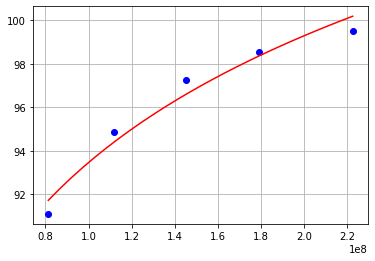

In [4]:
import matplotlib.pyplot as pl

pl.plot(bitrates, vmafs, 'bo')
pl.plot(xnew, interp_vmaf, 'r')
pl.grid(True)

#TODO: covariance testing, MSE assessment

The same but with RD:

In [56]:
import json
import numpy as np
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx

def log_fit(x, a, b, c): #anche polinomio 2 grado
    return a * np.log(x + b) + c      

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
rates = []
dists = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "hevc"):
        rates.append(item["bitrate"])
        dists.append(100 - item["vmaf"])
num_samples = (max(rates) - min(rates)) / 25 #to change

target_rate = 12000000
target_dist = 100 - 80
opt_dist = True

#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, rates, dists, maxfev=1000)
xrate = np.arange(min(rates), max(rates) + num_samples, num_samples)
ydist = np.asarray(log_fit(xrate, *popt))
if(opt_dist):
    crf = find_closest(ydist, target_dist)
else:
    crf = find_closest(xrate, target_rate)
print(crf + 15) #to change

22


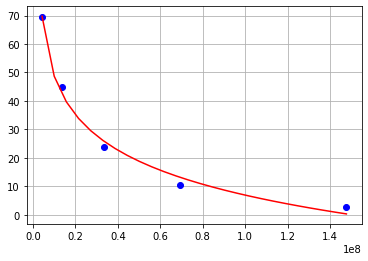

In [57]:
import matplotlib.pyplot as pl

pl.plot(rates, dists, 'bo')
pl.plot(xrate, ydist, 'r')
pl.grid(True)

In [61]:
#NORMALIZATION
rates = np.asarray(rates)
dists = np.asarray(dists)
nx = (xrate - min(xrate))/(max(xrate) - min(xrate))
ny = (ydist - min(ydist))/(max(ydist) - min(ydist))
#npopt, npcov = curve_fit(log_fit, nx, ny, maxfev=1000)
#num_samples = 1 / 25 #to change
#nxrate = np.arange(min(nx), max(nx) + num_samples, num_samples)
#nydist = np.asarray(log_fit(nxrate, *popt))
ncrf = np.argmin(np.sqrt(np.add(nx**2, ny**2))) 
print(ncrf + 15)

22


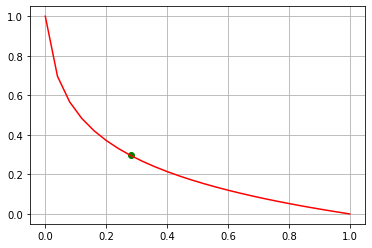

In [64]:
import matplotlib.pyplot as pl

x1 = nx[ncrf]
y1 = ny[ncrf]
pl.plot(x1, y1, 'go')
pl.plot(nx, ny, 'r')
pl.grid(True)

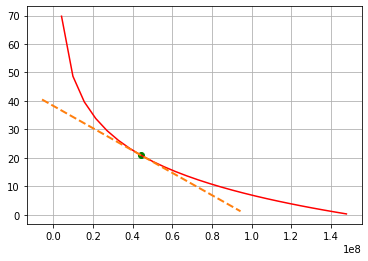

In [79]:
import matplotlib.pyplot as pl

def slope(x):
    return popt[0] / (x + popt[1])
def line(x, x1, y1):
    return slope(x1)*(x - x1) + y1
def show_tangent(x1,y1):
    # Define x data range for tangent line
    xrange = np.linspace(x1-50000000, x1+50000000, 2)
    pl.plot(xrange, line(xrange, x1, y1), 'C1--', linewidth = 2)

x1 = xrate[crf]
y1 = ydist[crf]

pl.plot(x1, y1, 'go')
pl.plot(xrate, ydist, 'r')
show_tangent(x1,y1)
pl.grid(True)

#TODO: linear inverse testing

## 2. Search
- Encode the first video at a fixed crf
- Encode two more versions with a +- delta of crf
- Compute VMAF quality metrics
- From RQ to RD points
- Which one of these three points is closer to the origin?
    - if it's the one in the middle reduce delta and repeat
    - if it's one of the outer, encode just one another video, with the same delta, in that direction
- Repeat until no more discrete crfs in between